In [117]:
'''
Test Set Statistics as required

1. species name
2. GC
3. intron density
4. # of genes in annotation
5. # of multi exon genes in annotation
6. # of genes in test set (multi-exon anchored)
'''
import pandas as pd
import subprocess
import matplotlib.pylab as plt
%matplotlib inline

In [118]:
def countGeneNumber(inputFile):
    'count number of genes from annotation'
    result = set()
    with open(inputFile) as f:
        for line in f:
            elems = line.split()
            result.add(elems[9])
    return len(result)

In [119]:
fullinfo = pd.read_csv('/home/richard/research/data_small/fullTableInfoGff3GffRNAESwithDensity20150829.csv')
fullinfo.index = fullinfo.shortName
filenames = filter(lambda x: len(x) < 15, os.listdir('/storage3/w/richard/meta2015/placeForRNASeq/'))

####1. collect info from full genome file

In [120]:
targetInfo = fullinfo.ix[filenames]
targetInfo[['shortName','longName','gc','intronDensityGff']]

,shortName,longName,gc,intronDensityGff
shortName,,,,
Aspoch1,Aspoch1,Aspergillus ochraceoroseus IBT 24754 v1.0,44.2,2.23
Disac1,Disac1,Dissoconium aciculare v1.0,52.7,1.17
Cenge3,Cenge3,Cenococcum geophilum 1.58 v2.0,37.5,1.93
Conli1,Conli1,Coniochaeta ligniaria CBS 111746,51.9,1.98
Trias1,Trias1,Trichoderma asperellum CBS 433.97 v1.0,47.3,1.68
Pneji1,Pneji1,Pneumocystis jirovecii,28.4,4.74
Ophdi1,Ophdi1,Ophiobolus disseminans CBS 113818 v1.0,51.7,1.59
HypEC38_1,HypEC38_1,Hypoxylon sp. EC38 v1.0,40.1,1.86
Hebcy2,Hebcy2,Hebeloma cylindrosporum h7 v2.0,48.4,4.24


####2. use eval package to calculate number of genes, number of multi-exon genes in annotation

In [95]:
# counter = 0
# for filename in filenames:
#     print counter, filename
#     counter+=1
#     print subprocess.Popen('ls /storage3/w/richard/meta2015/finalTestSet20151002/gtf_converted_from_gff/{}*.f.good.gtf'.format(filename),stdout=subprocess.PIPE,shell = True).communicate()[0]

2.1 from here we can see that Clafu1 is not working since the RNA-Seq Alignment was not completed

In [121]:
filenames = filter(lambda x: 'Clafu1' not in x, filenames)
targetInfo = fullinfo.ix[filenames]

2.2 run evaluate on these annotations

In [110]:
source = '/storage3/w/richard/meta2015/finalTestSet20151002/gtf_converted_from_gff/'
target = '/home/richard/research/tests/Oct27TestSetStatistics/annotation_original/'
target_simple = '/home/richard/research/tests/Oct27TestSetStatistics/annotation_original_simple/'
target_good = '/home/richard/research/tests/Oct27TestSetStatistics/annotation_good/'

In [41]:
mixAnnotationFiles = os.listdir(source)

In [44]:
original_annotation = (sc.parallelize(mixAnnotationFiles)
                       .filter(lambda x: '.c.' not in x)
                      .filter(lambda x: '.f.' not in x)
                      .filter(lambda x: 'out' not in x)
                      .collect())
good_annotation = (sc.parallelize(mixAnnotationFiles)
                   .filter(lambda x: 'good' in x)
                  .collect())

2.2.1 make script to run under eval folder

In [48]:
script = ''
for anno in original_annotation:
    script += 'perl evaluate_gtf.pl {}{} {}{} > {}{}.eval.txt\n'.format(source,anno,source,anno,target,anno)
with open('/home/richard/research/tests/Oct27TestSetStatistics/eval_lite/original_annotation.sh', 'w') as f: 
    f.write(script)

In [50]:
script = ''
for anno in good_annotation:
    script += 'perl evaluate_gtf.pl {}{} {}{} > {}{}.eval.txt\n'.format(source,anno,source,anno,target_good,anno)
with open('/home/richard/research/tests/Oct27TestSetStatistics/eval_lite/good_annotation.sh', 'w') as f: 
    f.write(script)

#### 3.1 Analyse eval output

In [54]:
good_annotation_eval = os.listdir(target_good)
good_gene_count = {}
good_singleExon_count = {}

In [70]:
for filename in good_annotation_eval:
    shortName = filename.split('_GeneCatalog')[0]
    flag = False
    with open(target_good+filename) as f:
        for line in f:
            if 'Total Transcripts' in line:
                elems = line.split()
                good_gene_count[shortName] = int(float(elems[2]))
                
            if 'Single Exon' in line:
                flag = True
            if flag and 'Count' in line:
                flag = False
                elems = line.split()
                good_singleExon_count[shortName] = int(float(elems[1]))
    

In [114]:
annotation_eval = os.listdir(target)
gene_count = {}
singleExon_count = {}

In [115]:
for filename in annotation_eval:
    shortName = filename.split('_GeneCatalog')[0]
    flag = False
    with open(target+filename) as f:
        for line in f:
            if 'Total Transcripts' in line:
                elems = line.split()
                gene_count[shortName] = int(float(elems[2]))
                
            if 'Single Exon' in line:
                flag = True
            if flag and 'Count' in line:
                flag = False
                elems = line.split()
                singleExon_count[shortName] = int(float(elems[1]))

 3.1.1 add results to table

In [124]:
targetInfo['geneCount'] = [gene_count[shortName] for shortName in targetInfo.index]
targetInfo['singleExonCount'] = [singleExon_count[shortName] for shortName in targetInfo.index]
targetInfo['multiExonGeneCount'] = targetInfo.geneCount - targetInfo.singleExonCount

In [129]:
targetInfo['goodGeneCount'] = [good_gene_count[shortName] for shortName in targetInfo.index]
targetInfo['goodSingleExonCount'] = [good_singleExon_count[shortName] for shortName in targetInfo.index]
targetInfo['goodMultiExonGeneCount'] = targetInfo.goodGeneCount - targetInfo.goodSingleExonCount

sub_info = (targetInfo[['shortName','longName','gc','intronDensityGff','geneCount','singleExonCount',\
                       'multiExonGeneCount','goodGeneCount','goodSingleExonCount','goodMultiExonGeneCount']])

In [130]:
result = sub_info[sub_info.goodMultiExonGeneCount > 100]

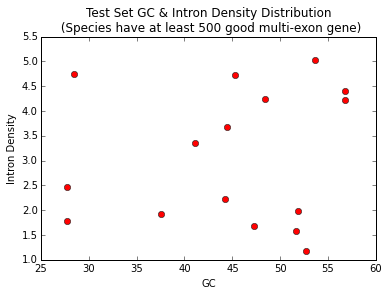

In [138]:
plt.plot(result.gc, result.intronDensityGff,'ro'); 
plt.title('Test Set GC & Intron Density Distribution\n (Species have at least 500 good multi-exon gene)')
plt.xlabel('GC'); 
plt.ylabel('Intron Density'); 
plt.show()

In [134]:
sub_info.to_csv('/home/richard/research/tests/Oct27TestSetStatistics/testSetStatistics.csv',index = False)